# Setup

In [1]:
import torch

if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  running_on_colab = True
else:
  print('Not running on Colab')
  running_on_colab = False

if running_on_colab:
    print(torch.__version__)
    !pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
    !pip install -q git+https://github.com/snap-stanford/deepsnap.git
    !pip install pyarrow
    !pip install fastparquet

    from google.colab import drive
    drive.mount('/content/drive')
    filepath = '/content/drive/MyDrive/GCNN/'
    data_folder = filepath+"graph_data/split_dataset/"
    feature_folder = data_folder
    experiments_folder = filepath+"experiments/random_walks/"
    import sys
    sys.path.append(filepath + "run_in_colab")

else:
    data_folder = "../../../data/processed/graph_data_nohubs/merged_types/split_dataset/"
    experiments_folder = "../../../data/experiments/design_space_merged_experiment/"
    feature_folder = "../../../data/processed/feature_data/"

Not running on Colab


In [2]:
import base_model, colab_utils
import pandas as pd
import datetime
import os
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch_geometric import seed_everything
import copy
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed_everything(0)

# Load data

In [4]:
seeds = [4,5,6,7,8]
data = []
for seed in seeds:
    datasets, node_map = colab_utils.load_data(data_folder+f"seed_{seed}/")
    data.append(datasets)

full_set = torch.load(data_folder+f"seed_{seeds[-1]}/full_dataset.pt")

#cargar esto solo para recuperar pasos anteriores y no repetirlos
# with open(data_folder+"walks_3_4_steps.pickle", 'rb') as handle:
#     step_history = pickle.load(handle)

# Experiment

In [6]:
def run_experiment(params, train_set, val_set,negative_sampler,feature_folder=feature_folder):
    # Initialize node features
    if params["feature_type"] in ["random","random_xavier","ones"]:
        train_set = colab_utils.initialize_features(
            train_set, params["feature_type"], params["feature_dim"]
        )
        val_set = colab_utils.initialize_features(
            val_set, params["feature_type"], params["feature_dim"]
        )
    else:
        #TODO: sacar el data_folder este --> no xq pase las features a otro dir, esta bien avisarle donde estan
        train_set = colab_utils.initialize_features(
            train_set, params["feature_type"], params["feature_dim"], feature_folder
        )
        val_set = colab_utils.initialize_features(
            val_set, params["feature_type"], params["feature_dim"], feature_folder
        )

    train_set.to(device)
    val_set.to(device)

    # Initialize model
    model = base_model.base_model(
        params, train_set.metadata(), params["supervision_types"]
    )
    model = model.to(device)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"]
    )
    train_losses = []
    val_losses = []
    train_scores = []
    val_scores = []

    epochs = params["epochs"]

    early_stopper = colab_utils.EarlyStopper(params["patience"], params["delta"])
    train_label_index = train_set["gene_protein","gda","disease"]["edge_label_index"]
    for epoch in range(epochs):
        #Resample negative supervision links every k epochs
        if epoch%params["sample_epochs"] == 0:
            # sample_index = torch.randint(high=train_label_index.shape[1], size=(round(params["sample_ratio"]*train_label_index.shape[1]),))
            # positive_sample = train_label_index[:,sample_index]

            # positive_sample = train_label_index
            new_train_label_index, new_train_label = negative_sampler.get_labeled_tensors(train_label_index.cpu(),"corrupt_both")
            train_set["gene_protein","gda","disease"]["edge_label_index"] = new_train_label_index.to(device)
            train_set["gene_protein","gda","disease"]["edge_label"] = new_train_label.to(device)

        train_loss = colab_utils.train(model, optimizer, train_set)
        val_loss = colab_utils.get_val_loss(model, val_set)

        train_score = colab_utils.test(model, train_set)
        val_score = colab_utils.test(model, val_set)

        train_losses.append(train_loss)
        train_scores.append(train_score)

        val_scores.append(val_score)
        val_losses.append(val_loss)

        if early_stopper.early_stop(val_loss):
            print("Early stopping")
            break

    val_auc = colab_utils.test(model, val_set)
    curve_data = [train_losses, val_losses, train_scores, val_scores]

    return val_auc, model, curve_data

def run_multiple_seeds(datasets,experiment_params,negative_sampler):
    experiment_metrics = []
    models = []
    curves = []
    for seed_dataset in datasets:
        train_data, val_data = seed_dataset
        seed_auc, trained_model, training_curve = run_experiment(experiment_params,train_data,val_data,negative_sampler)
        experiment_metrics.append(seed_auc)
        models.append(trained_model)
        curves.append(training_curve)
    
    metrics = (np.mean(experiment_metrics),np.std(experiment_metrics))
    
    return [metrics, models, curves]

In [7]:
class ParameterWalker():
    def __init__(self, start, possible_params) -> None:
        self.possible_params = possible_params
        self.start = start
        self.historial = [list(start.values())]
        self.dimensions = np.array(list(self.possible_params.keys()))
        self.current_params = copy.copy(start)
    
    def update_params(self):
        chosen_dim = np.random.choice(self.dimensions,1)[0]
        values = self.possible_params[chosen_dim]
        flip_coin = np.random.choice([-1,1],1)[0]
        current_index = values.index(self.current_params[chosen_dim])
        new_index = (current_index + flip_coin)% len(values)

        new_params = copy.copy(self.current_params)
        new_params[chosen_dim] = values[new_index]
        # print(new_params[chosen_dim])
        self.current_params = new_params
        return new_params

    def random_step(self):
        chosen_dim = np.random.choice(self.dimensions,1)[0]
        values = self.possible_params[chosen_dim]
        flip_coin = np.random.choice([-1,1],1)[0]
        current_index = values.index(self.current_params[chosen_dim])
        new_index = (current_index + flip_coin)% len(values)

        new_params = copy.copy(self.current_params)
        new_params[chosen_dim] = values[new_index]
        # print(new_params[chosen_dim])
        # self.current_params = new_params
        return new_params

    def next(self):
        new_params = self.random_step()
        while list(new_params.values()) in self.historial:
            new_params = self.random_step()
        # self.historial.append(list(new_params.values()))
        return new_params
    
    def accept_step(self,new_params):
        self.current_params = new_params
        self.historial.append(list(new_params.values()))

class ConvergenceTest:
    def __init__(self, delta,tolerance):
        self.tolerance = tolerance
        self.delta = delta
        self.counter = 0
        self.prev_auc = 0
    
    def check_convergence(self,current_auc):
        diff = round(abs(current_auc - self.prev_auc),3)
        if diff <= self.delta:
            self.counter += 1
        else:
            self.counter = 0
            
        self.prev_auc = current_auc
        
        if self.counter >= self.tolerance:
            return True
        else:
            return False

In [8]:
class RandomWalk():
    def __init__(self,T,max_steps,step_tolerance,diff_delta,max_keep,start_params,fixed_params,negative_sampler,model_param_grid):
        self.T = T
        self.max_steps = max_steps
        self.convergence_test = ConvergenceTest(diff_delta,step_tolerance)

        self.keep_models = deque(maxlen=max_keep)
        self.keep_curves = deque(maxlen=max_keep)
        self.top_5_scores = deque(maxlen=max_keep)
        self.top_5_ids = deque(maxlen=max_keep)

        self.auc_chain = []
        self.std_chain = []
        self.param_chain = []

        self.fixed_params = fixed_params
        self.start_params = start_params
        self.negative_sampler = negative_sampler
        self.model_param_grid = model_param_grid

        self.param_walker = ParameterWalker(start_params,model_param_grid)
    
    def random_walk(self,datasets):
        current_params = self.start_params|self.fixed_params
        current_metrics, current_models, current_curves = run_multiple_seeds(datasets,current_params,self.negative_sampler)
        current_auc,current_std = current_metrics
        converged = self.convergence_test.check_convergence(current_auc)

        self.auc_chain.append(current_auc)
        self.std_chain.append(current_std)
        self.keep_models.append(current_models)
        self.keep_curves.append(current_curves)
        self.param_chain.append(current_params)
        self.top_5_scores.append(current_auc)

        i = 0
        j = 0
        while i < self.max_steps-1:
            print(f"Iter {i} of {self.max_steps}. Step {j}")
            new_params = self.param_walker.next()|self.fixed_params
            new_metrics, new_models, new_curves = run_multiple_seeds(datasets,new_params,self.negative_sampler)
            new_auc, new_std = new_metrics
            delta = new_auc - current_auc
            P = min([np.exp(delta/self.T),1])
            roll = np.random.rand()
            accept_step = roll < P 
            if accept_step:
                self.param_walker.accept_step(new_params)
                self.auc_chain.append(new_auc)
                self.std_chain.append(new_std)
                self.param_chain.append(new_params)
                
                current_auc = new_auc
                print(current_auc)
                converged = self.convergence_test.check_convergence(current_auc)

                if (new_auc > np.min(self.top_5_scores)) or (j < 5):
                    self.keep_models.append(new_models)
                    self.keep_curves.append(new_curves)
                    self.top_5_scores.append(new_auc)
                    self.top_5_ids.append(j)
                    
                j+=1
            i += 1
            if converged:
                print("Random walk converged")
                break
            
        plt.errorbar(np.arange(len(self.auc_chain)), self.auc_chain, self.std_chain, fmt="o")
        plt.xlabel("Step")
        plt.ylabel("AUROC")
        plt.grid(True)
        
        return self.auc_chain, self.std_chain, self.param_chain, list(self.keep_models), list(self.keep_curves), list(self.top_5_ids)

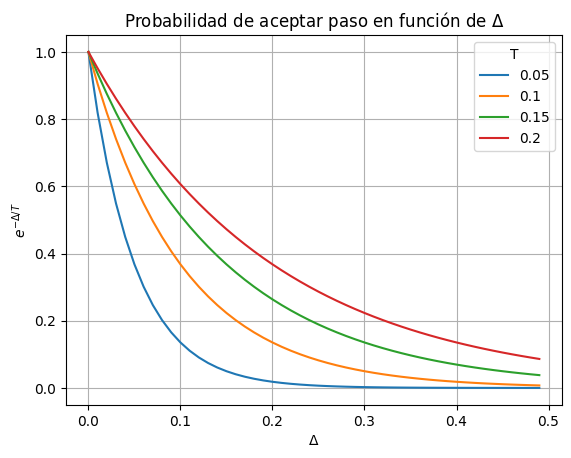

In [9]:
temperaturas = [0.05,0.1,0.15,0.2]
x = np.arange(0,0.5,0.01)

plt.figure()
for temp in temperaturas:
    y = np.exp(-x/temp)
    plt.plot(x,y,label=temp)

plt.xlabel("$\Delta$")
plt.ylabel("$e^{-\Delta /T}$")
plt.title("Probabilidad de aceptar paso en función de $\Delta$")
plt.legend(title="T")
plt.grid(True)

In [10]:
model_param_grid = {
    "hidden_channels": [32, 64],
    "micro_aggregation": ["mean", "sum", "max"],
    "macro_aggregation": ["mean", "sum", "max"],
    "layer_connectivity": [None, "skipsum"],
    "L2_norm": [True, False],
    "pre_process_layers": [0, 1, 2],
    "msg_passing_layers": [2, 3, 4],
    "post_process_layers": [0, 1, 2],
    "normalize_output": [False, True],
    "jumping_knowledge": [True, False],
    "feature_dim": [16, 32, 64],
    "feature_type": ["random_xavier", "ones", "lsa_scaled"],
}

fixed_params = {
    "conv_type": "SAGEConv",
    "batch_norm": True,
    "dropout": 0.1,
    "weight_decay": 1e-3,
    "lr": 1e-3,
    "epochs": 400,
    "patience": 10,
    "delta": 0.1,
    "sample_epochs": 10,
    "supervision_types": [("gene_protein", "gda", "disease")],
}

start_params = {
    "hidden_channels": 64,
    "conv_type": "SAGEConv",
    "micro_aggregation": "mean",
    "macro_aggregation": "max",
    "layer_connectivity": "skipsum",
    "L2_norm": "True",
    "pre_process_layers": 0,
    "msg_passing_layers": 3,
    "post_process_layers": 0,
    "normalize_output": "True",
    "jumping_knowledge": "False",
    "feature_dim": 64,
    "feature_type": "random_xavier",
}

In [11]:
T = 0.05
steps = 100
max_keep = 5
step_tolerance = 5
diff_delta = 0.01

negative_sampler = colab_utils.NegativeSampler(full_set,("gene_protein","gda","disease"),full_set["gene_protein"]["degree_gda"],full_set["disease"]["degree_gda"])
random_walker = RandomWalk(T,steps,step_tolerance,diff_delta,max_keep,start_params,fixed_params,negative_sampler,model_param_grid)

# for step in step_history.values():
#     random_walker.param_walker.accept_step(step)

In [113]:
auc_chain, std_chain, param_chain, kept_models, kept_curves, kept_ids = random_walker.random_walk(data)

df = pd.DataFrame(param_chain)
df["mean_auc"] = auc_chain
df["std"] = std_chain

date = datetime.datetime.now()
fdate = date.strftime("%d_%m_%y__%H_%M")

folder = experiments_folder + fdate + "/"
if not os.path.exists(folder):
    print("folder dir does not exist, a new directory will be created")
    os.makedirs(folder)

df.to_csv(f"{folder}random_walk_results.csv")

plt.errorbar(np.arange(len(auc_chain)), auc_chain, std_chain, fmt="o")
plt.xlabel("Step")
plt.ylabel("AUROC")
plt.grid(True)

plt.savefig(f"{folder}random_walk_plot.png")
walk_parameters = f"T:{T}, max_steps:{steps}, tolerance:{step_tolerance},diff_delta:{diff_delta}, final_iterations:{len(auc_chain)}"
with open(f"{folder}walk_parameters.txt", "w") as f:
    f.write(walk_parameters)

# kept_indices = df.tail(max_keep).index.values
for models, curves, index in zip(kept_models,kept_curves,kept_ids):
    models_name = f"step_{index}"
    curve_data = np.array(curves, dtype=object)
    np.save(folder+models_name+"_curve.npy", curve_data)
    # curve_data = [train_losses, val_losses, train_scores, val_scores]
    # por cada paso hay N_seeds modelos
    for i, model in enumerate(models):
        fname = f"{models_name}_{i}"
        torch.save(model.state_dict(), f"{folder}{fname}.pth")

Iter 0 of 100. Step 0


KeyboardInterrupt: 

In [ ]:
auc_chain = random_walker.auc_chain
std_chain = random_walker.std_chain
param_chain = random_walker.param_chain
kept_models = list(random_walker.keep_models)
kept_curves = list(random_walker.keep_curves)
kept_ids = list(random_walker.top_5_ids)

df = pd.DataFrame(param_chain)
df["mean_auc"] = auc_chain
df["std"] = std_chain

date = datetime.datetime.now()
fdate = date.strftime("%d_%m_%y__%H_%M")

folder = experiments_folder + fdate + "/"
if not os.path.exists(folder):
    print("folder dir does not exist, a new directory will be created")
    os.makedirs(folder)

df.to_csv(f"{folder}random_walk_results.csv")

plt.errorbar(np.arange(len(auc_chain)), auc_chain, std_chain, fmt="o")
plt.xlabel("Step")
plt.ylabel("AUROC")
plt.grid(True)

plt.savefig(f"{folder}random_walk_plot.png")
walk_parameters = f"T:{T}, max_steps:{steps}, tolerance:{step_tolerance},diff_delta:{diff_delta}, final_iterations:{len(auc_chain)}"
with open(f"{folder}walk_parameters.txt", "w") as f:
    f.write(walk_parameters)

# kept_indices = df.tail(max_keep).index.values
for models, curves, index in zip(kept_models,kept_curves,kept_ids):
    models_name = f"step_{index}"
    curve_data = np.array(curves, dtype=object)
    np.save(folder+models_name+"_curve.npy", curve_data)
    # curve_data = [train_losses, val_losses, train_scores, val_scores]
    # por cada paso hay N_seeds modelos
    for i, model in enumerate(models):
        fname = f"{models_name}_{i}"
        torch.save(model.state_dict(), f"{folder}{fname}.pth")

folder dir does not exist, a new directory will be created
